# On Spatial Domain Discretization

---

## <a id="Contents"></a>   Contents

- [Core](#Core)
- [Experiment](#Experiment)
- [MSE and CFL number vs number of grid points](#MSE-and-CFL-number-vs-number-of-grid-points)
- [Analytic vs numerical solutions ](#Analytic-vs-numerical-solutions)
- [Finite time blowup](#Finite-time-blowup)

---

In [1]:
import matplotlib, numpy, os, pickle
from sklearn.metrics import mean_squared_error as calc_MSE
from matplotlib import colors as mcolors
from matplotlib import pyplot

# Import custom utility module
import sys
sys.path.insert(1, "../utility")
from utils import SimulationData, build_banded_matrix

%matplotlib inline

In [13]:
# Initialize data
data = SimulationData(
    R=3e-3, L=1e-3, G=1e-3, C=1e3,
    X=1.0, T=1.0, num_x_points=100, num_t_points=1000,
    mu_0 = lambda x : numpy.sin(5*numpy.pi*x) + 2*numpy.sin(7*numpy.pi*x),
    xi_0 = 0.,
    nu_0 = lambda t : 0., nu_X = lambda t : 0.,
    name="experiment_02"
)
print(f"CFL number = {data.get_CFL_number()}")
print(f"c = {data.line['c']}; c^2 = {data.line['c squared']}")
print(f"X = {data.domain['X']}; T = {data.domain['T']}")

Line parameters initialized.
Domain parameters initialized.
CFL number = 0.09909909909909909
c = 1.0; c^2 = 1.0
X = 1.0; T = 1.0


CFL number = 0.09909909909909909
c = 1.0; c^2 = 1.0
X = 1.0; T = 1.0


In [10]:
f"{data.line['R']}"

'0.003'

In [6]:
data.line.keys()

dict_keys(['R', 'L', 'G', 'C', 'c', 'c squared', 'alpha', 'beta'])

In [7]:
data.domain.keys()

dict_keys(['X', 'T', 'K', 'N', 'x step', 't step'])

## <a id="Core"></a>   Core

In [1]:
import matplotlib, numpy, os, pickle
from sklearn.metrics import mean_squared_error as calc_MSE
from matplotlib import colors as mcolors
from matplotlib import pyplot

# Import custom utility module
import sys
sys.path.insert(1, "../utility")
from utils import SimulationData, build_banded_matrix

%matplotlib inline

In [2]:
# Initialize data
data = SimulationData(
    R=3e-3, L=1e-3, G=0, C=1e3,
    X=1.0, T=1.0, num_x_points=100, num_t_points=1000,
    mu_0 = lambda x : numpy.sin(5*numpy.pi*x) + 2*numpy.sin(7*numpy.pi*x),
    xi_0 = 0.,
    nu_0 = lambda t : 0., nu_X = lambda t : 0.,
    name="experiment_02"
)
print(f"CFL number = {data.get_CFL_number()}")

Line parameters initialized.
Domain parameters initialized.
CFL number = 0.09909909909909909


In [3]:
# Analytic solution
def u_x_t(x,t):
    a = 1.5
    c = 1.0
    def theta(k):
        return numpy.sqrt((c*k*numpy.pi)**2 - a**2)
    
    u = numpy.sin(5*numpy.pi*x) * (numpy.cos(theta(5)*t) + (a/theta(5))*numpy.sin(theta(5)*t))
    u += 2*numpy.sin(7*numpy.pi*x) * (numpy.cos(theta(7)*t) + (a/theta(7))*numpy.sin(theta(7)*t))
    u *= numpy.exp(-a*t)
    
    return u

In [4]:
# Experiment parameters
num_x_points = numpy.array([100*i for i in numpy.linspace(0.5,10.25,30)], dtype=int)
MSEs = numpy.zeros(num_x_points.shape)
save_dir = "./results"

[Back to Contents](#Contents)

---

## <a id="Experiment"></a>   Experiment

In [5]:
for i, K_plus_1 in enumerate(num_x_points):
    print(f"Simulating with K = {K_plus_1-1}")
    # Set data
    print(" ", end="")
    data.set_domain(num_x_points=K_plus_1)
    print(f" CFL number = {data.get_CFL_number()}")
    
    # Update scheme parameters
    A = 1. + 0.5 * data.domain["t step"] * (data.line["alpha"] + data.line["beta"])
    B = 1. - 0.5 * data.domain["t step"] * (data.line["alpha"] + data.line["beta"])
    E = data.line["c squared"] * data.domain["t step"]**2 / data.domain["x step"]**2
    F = 2. - (2. * data.line["c squared"] * data.domain["t step"]**2 / data.domain["x step"]**2) - (data.line["alpha"] * data.line["beta"] * data.domain["t step"]**2)
    E_matrix = build_banded_matrix(numpy.array([E, F, E]), data.domain["K"]-1)
    B_matrix = B*numpy.concatenate(
        (numpy.zeros((data.domain["K"]-1,1)), numpy.identity(data.domain["K"]-1), numpy.zeros((data.domain["K"]-1,1))),
        axis=1
    )
    
    # Get discretized domains
    x_domain = data.get_x_domain()
    t_domain = data.get_t_domain()
    
    # Intitialize container for voltages
    u = numpy.zeros((data.domain["K"]+1, data.domain["N"]+1))
    u_hat = numpy.zeros((data.domain["K"]+1, data.domain["N"]+1))

    # Initial conditions
    u_hat[:,0] = data.init_condition_value(x_domain)
    u_hat[0,0] = data.dirichlet_sending_end(t_domain[0])
    u_hat[-1,0] = data.dirichlet_receiving_end(t_domain[0])
    u_hat[:,1] = data.init_condition_deriv(u_hat[:,0])
    u_hat[0,1] = data.dirichlet_sending_end(t_domain[1])
    u_hat[-1,1] = data.dirichlet_receiving_end(t_domain[1])
    
    # n=1,2,...,N-1
    for n in range(1,data.domain["N"]):
        u_was, u_now = u_hat[:,n-1], u_hat[:,n]
        # k=1,2,...,K-1
        tilde_u_nxt = numpy.dot(E_matrix, u_now) - numpy.dot(B_matrix, u_was)
        tilde_u_nxt /= A
        # k=0,1,...,K
        u_nxt = numpy.concatenate(
            (numpy.array([data.dirichlet_sending_end(t_domain[n+1])]),
             tilde_u_nxt,
             numpy.array([data.dirichlet_receiving_end(t_domain[n+1])]))
        )
        u_hat[:,n+1] = u_nxt
    
    # Calculate analytic solution
    for k in range(0,data.domain["K"]+1):
        for n in range(0,data.domain["N"]+1):
            u[k,n] = u_x_t(x_domain[k],t_domain[n])

    # Calculate and record MSE
    MSE = calc_MSE(u, u_hat)
    print(f" MSE = {MSE}")
    
    # Save results
    result = {
        "CFL number" : data.get_CFL_number(),
        "analytic solution" : u,
        "numerical solution" : u_hat,
        "MSE" : MSE,
    }
    with open(os.path.join(save_dir, f"{K_plus_1}-x-points.pkl"), 'wb') as file:
        pickle.dump(result, file)
    
    print("Results saved to " + os.path.join(save_dir, f"{K_plus_1}-x-points.pkl."))

del i, K_plus_1
del A, B, E, F, E_matrix, B_matrix
del x_domain, t_domain
del n, u, u_hat, tilde_u_nxt, u_nxt
del MSE, result, file

Simulating with K = 49
 Domain parameters 'K' and 'x step' are adjusted.
 CFL number = 0.049049049049049054
 MSE = 0.0019334195118160438
Results saved to ./results\50-x-points.pkl.
Simulating with K = 82
 Domain parameters 'K' and 'x step' are adjusted.
 CFL number = 0.08208208208208208
 MSE = 0.00037297313724347437
Results saved to ./results\83-x-points.pkl.
Simulating with K = 116
 Domain parameters 'K' and 'x step' are adjusted.
 CFL number = 0.11611611611611612
 MSE = 0.00015917381676660067
Results saved to ./results\117-x-points.pkl.
Simulating with K = 149
 Domain parameters 'K' and 'x step' are adjusted.
 CFL number = 0.14914914914914915
 MSE = 0.00010154354786826619
Results saved to ./results\150-x-points.pkl.
Simulating with K = 183
 Domain parameters 'K' and 'x step' are adjusted.
 CFL number = 0.1831831831831832
 MSE = 7.75700958470606e-05
Results saved to ./results\184-x-points.pkl.
Simulating with K = 217
 Domain parameters 'K' and 'x step' are adjusted.
 CFL number = 0.21

C:\Users\yanya\miniconda3\envs\telfindiff\lib\site-packages\sklearn\metrics\_regression.py:258: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
C:\Users\yanya\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[Back to Contents](#Contents)

---

## <a id="MSE-and-CFL-number-vs-number-of-grid-points"></a>   MSE and CFL number vs number of grid points

In [5]:
# Load results
results = []
for K_plus_1 in num_x_points:
    with open(os.path.join(save_dir, f"{K_plus_1}-x-points.pkl"), 'rb') as file:
        result = pickle.load(file)
        results.append(result)
    print("Loaded " + os.path.join(save_dir, f"{K_plus_1}-x-points.pkl"))
del K_plus_1, file, result

Loaded ./results\50-x-points.pkl
Loaded ./results\83-x-points.pkl
Loaded ./results\117-x-points.pkl
Loaded ./results\150-x-points.pkl
Loaded ./results\184-x-points.pkl
Loaded ./results\218-x-points.pkl
Loaded ./results\251-x-points.pkl
Loaded ./results\285-x-points.pkl
Loaded ./results\318-x-points.pkl
Loaded ./results\352-x-points.pkl
Loaded ./results\386-x-points.pkl
Loaded ./results\419-x-points.pkl
Loaded ./results\453-x-points.pkl
Loaded ./results\487-x-points.pkl
Loaded ./results\520-x-points.pkl
Loaded ./results\554-x-points.pkl
Loaded ./results\587-x-points.pkl
Loaded ./results\621-x-points.pkl
Loaded ./results\655-x-points.pkl
Loaded ./results\688-x-points.pkl
Loaded ./results\722-x-points.pkl
Loaded ./results\756-x-points.pkl
Loaded ./results\789-x-points.pkl
Loaded ./results\823-x-points.pkl
Loaded ./results\856-x-points.pkl
Loaded ./results\890-x-points.pkl
Loaded ./results\924-x-points.pkl
Loaded ./results\957-x-points.pkl
Loaded ./results\991-x-points.pkl
Loaded ./results

In [6]:
# Extract CFL numbers
epsilons = [result["CFL number"] for result in results]

# Extract MSEs
MSEs = [result["MSE"] for result in results]

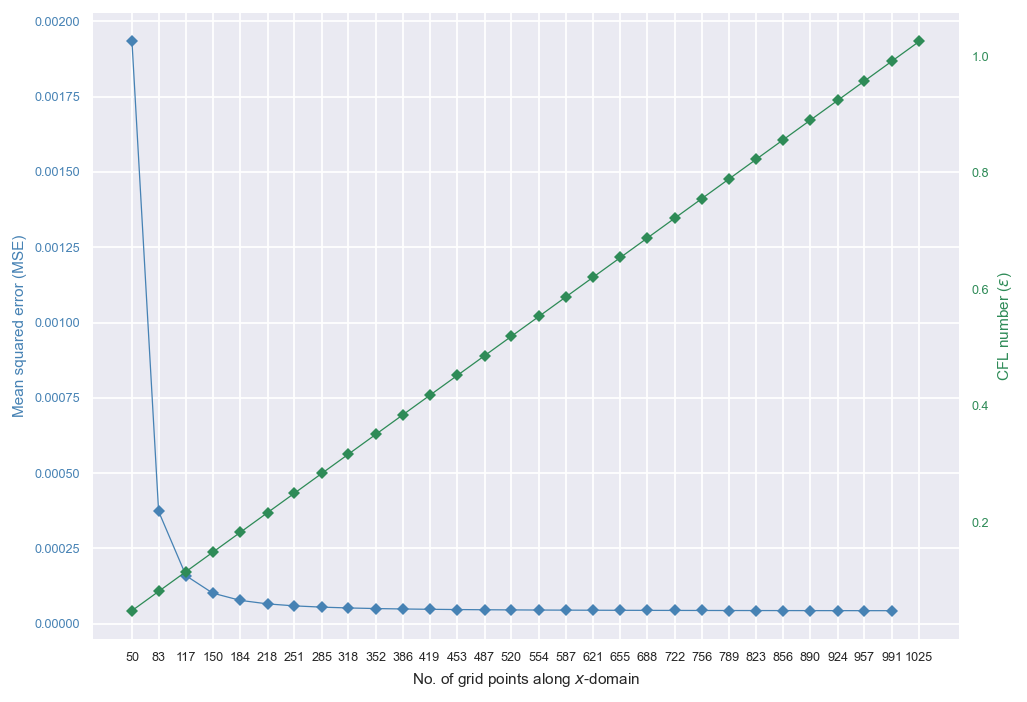

In [7]:
# Visualize
matplotlib.style.use("seaborn")
figure = pyplot.figure(dpi=130)

# Plot MSEs vs number of grid points
axes_MSE = figure.add_subplot(1,1,1)
axes_MSE.set_xlabel("No. of grid points along $x$-domain", fontsize=8.5)
axes_MSE.set_ylabel("Mean squared error (MSE)", fontsize=8.5, color=mcolors.CSS4_COLORS['steelblue'])
axes_MSE.tick_params(labelsize=7)
axes_MSE.tick_params(axis='y', labelcolor=mcolors.CSS4_COLORS['steelblue'])
pyplot.xticks(ticks=num_x_points, labels=[f"{K_plus_1}" for K_plus_1 in num_x_points])
axes_MSE.plot(num_x_points, MSEs, color=mcolors.CSS4_COLORS['steelblue'], marker='D', markersize=5, linewidth=0.7)
axes_MSE.grid(True)

# Plot CFL numbers vs number of grid points
axes_CFL = axes_MSE.twinx()
axes_CFL.set_ylabel("CFL number ($\epsilon$)", fontsize=8.5, color=mcolors.CSS4_COLORS['seagreen'])
axes_CFL.tick_params(labelsize=7)
axes_CFL.tick_params(axis='y', labelcolor=mcolors.CSS4_COLORS['seagreen'])
axes_CFL.plot(num_x_points, epsilons, color=mcolors.CSS4_COLORS['seagreen'], marker='D', markersize=5, linewidth=0.7)
axes_CFL.grid(False)

figure.tight_layout()

In [8]:
# Save summary
figure.savefig(os.path.join(save_dir, "MSE and CFL.png"), dpi=300, facecolor=None, edgecolor=None, bbox_inches="tight", pad_inches=0.05)

[Back to Contents](#Contents)

---

## <a id="Analytic-vs-numerical-solutions"></a>   Analytic vs numerical solutions

In [5]:
print("Investigating:")

# Select arbitrary spatial domain discretization scheme
K_plus_1s_to_observe = num_x_points[numpy.sort(numpy.random.choice(len(num_x_points), size=(5,)))]
K_plus_1s_to_observe[-1] = num_x_points[-2]
print(f"  for K = {list(K_plus_1s_to_observe)}")

# Select arbitrary temporal grid points to observe
ns_to_observe = numpy.sort(numpy.random.choice(1000, size=(4,)))
ns_to_observe[0], ns_to_observe[-1]  = 20, 999
print(f"  at n = {list(ns_to_observe)}")

Investigating:
  for K = [285, 386, 520, 554, 991]
  at n = [20, 373, 553, 999]


In [6]:
# Load necessary results
results = []
for K_plus_1_to_observe in K_plus_1s_to_observe:
    with open(os.path.join(save_dir, f"{K_plus_1_to_observe}-x-points.pkl"), 'rb') as file:
        result = pickle.load(file)
        results.append(result)
        print("Loaded " + os.path.join(save_dir, f"{K_plus_1_to_observe}-x-points.pkl"))
del K_plus_1_to_observe, file, result

Loaded ./results\285-x-points.pkl
Loaded ./results\386-x-points.pkl
Loaded ./results\520-x-points.pkl
Loaded ./results\554-x-points.pkl
Loaded ./results\991-x-points.pkl


In [7]:
# Extract necessary discretized x domains
x_domains = []
for K_plus_1_to_observe in K_plus_1s_to_observe:
    data.set_domain(num_x_points=K_plus_1_to_observe)
    x_domain = data.get_x_domain()
    x_domains.append(x_domain)
del K_plus_1_to_observe, x_domain

# Extract the discretized t domain
t_domain = data.get_t_domain()

Domain parameters 'K' and 'x step' are adjusted.
Domain parameters 'K' and 'x step' are adjusted.
Domain parameters 'K' and 'x step' are adjusted.
Domain parameters 'K' and 'x step' are adjusted.
Domain parameters 'K' and 'x step' are adjusted.


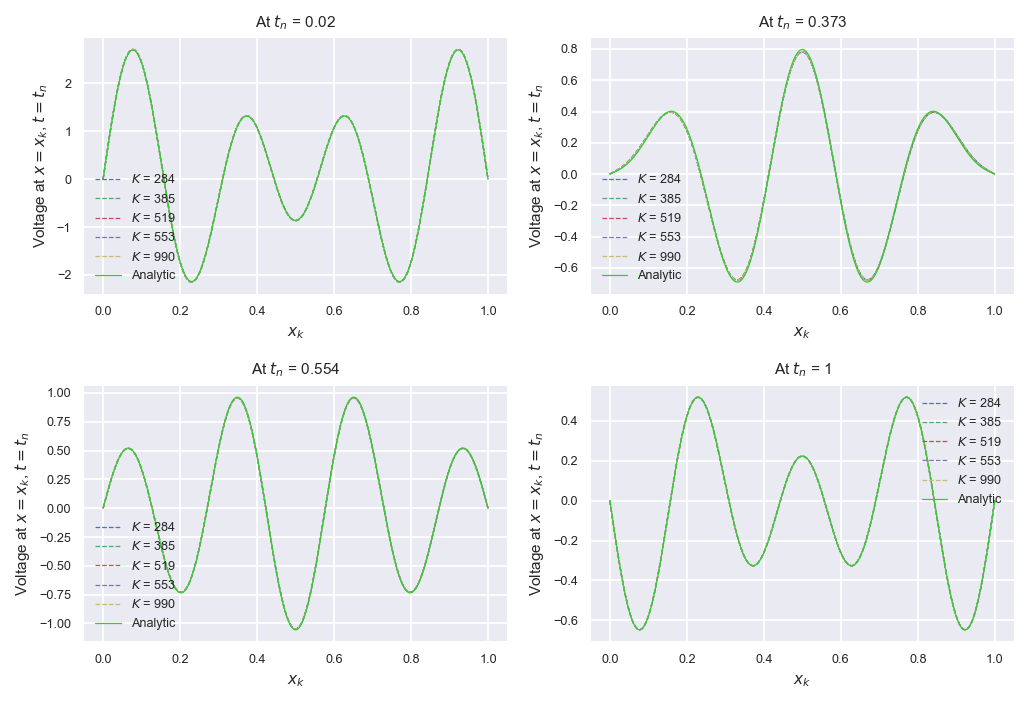

In [8]:
# Visualize
matplotlib.style.use("seaborn")
figure = pyplot.figure(dpi=130)

for i, n_to_observe in enumerate(ns_to_observe):
    axes = figure.add_subplot(2,2,i+1)
    axes.set_title(f"At $t_n$ = {t_domain[n_to_observe]:.3g}", fontsize=8.5)
    axes.set_xlabel("$x_k$", fontsize=8.5)
    axes.set_ylabel("Voltage at $x=x_k$, $t=t_n$", fontsize=8.5)
    axes.tick_params(labelsize=7)
    
    # Plot numerical solutions
    for j, K_plus_1_to_observe in enumerate(K_plus_1s_to_observe):
        axes.plot(x_domains[j], results[j]["numerical solution"][:,n_to_observe], label=f"$K$ = {K_plus_1_to_observe-1}", linestyle='--', linewidth=0.7)
    
    # Plot analytic solution (evaluated at the finest discretization)
    axes.plot(x_domains[-1], results[-1]["analytic solution"][:,n_to_observe], label="Analytic", color=mcolors.CSS4_COLORS['limegreen'], linewidth=0.7)
    
    axes.grid(True)
    axes.legend(loc="best", fontsize=7);

figure.tight_layout()
del i, n_to_observe, axes, j, K_plus_1_to_observe

In [9]:
# Save summary
figure.savefig(os.path.join(save_dir, "Analytic vs numerical.png"), dpi=300, facecolor=None, edgecolor=None, bbox_inches="tight", pad_inches=0.05)

[Back to Contents](#Contents)

---

## <a id="Finite-time-blowup"></a>   Finite time blowup

In [5]:
print("Investigating:")

# Select spatial domain discretization scheme with the most number of grid points
K_plus_1_to_observe = num_x_points[-1]
print(f"  for K = {K_plus_1_to_observe}")

# Select arbitrary temporal grid points to observe
ns_to_observe = numpy.sort(numpy.random.choice(1000, size=(2,)))
print(f"  at n = {list(ns_to_observe)}")

Investigating:
  for K = 1025
  at n = [84, 135]


In [6]:
# Load corresponding results
with open(os.path.join(save_dir, f"{K_plus_1_to_observe}-x-points.pkl"), 'rb') as file:
    result = pickle.load(file)
    print("Loaded " + os.path.join(save_dir, f"{K_plus_1_to_observe}-x-points.pkl"))
del file

Loaded ./results\1025-x-points.pkl


In [7]:
# Extract corresponding discretized x domain
data.set_domain(num_x_points=K_plus_1_to_observe)
x_domain = data.get_x_domain()

# Extract the discretized t domain
t_domain = data.get_t_domain()

Domain parameters 'K' and 'x step' are adjusted.


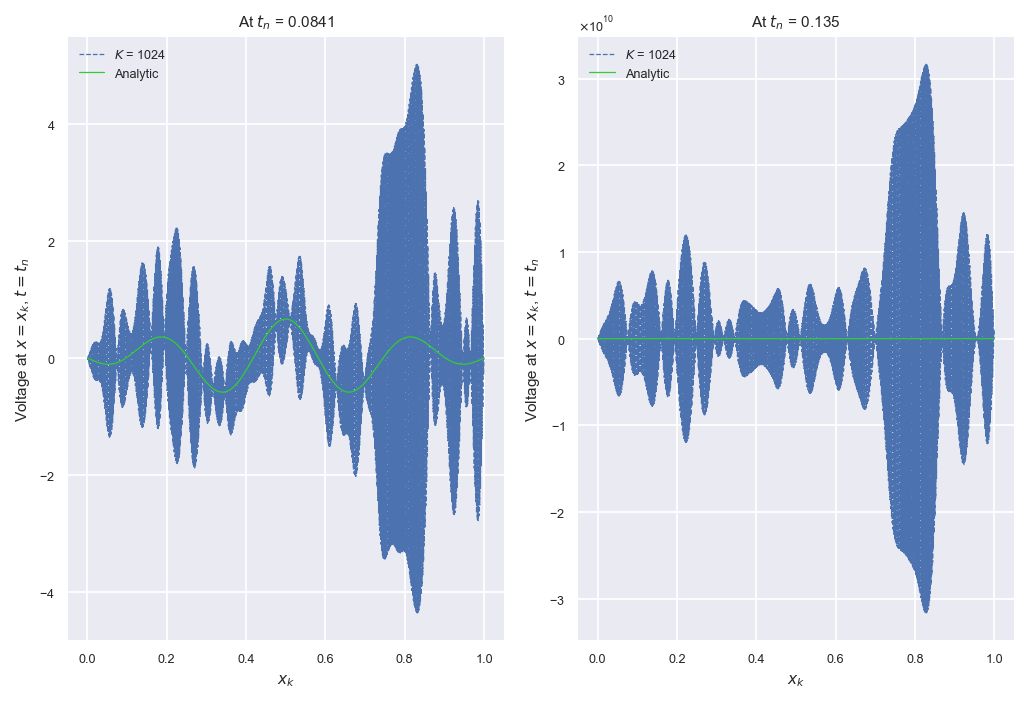

In [8]:
# Visualize
from matplotlib.ticker import ScalarFormatter
matplotlib.style.use("seaborn")
figure = pyplot.figure(dpi=130)

for i, n_to_observe in enumerate(ns_to_observe):
    axes = figure.add_subplot(1,2,i+1)
    axes.set_title(f"At $t_n$ = {t_domain[n_to_observe]:.3g}", fontsize=8.5)
    axes.set_xlabel("$x_k$", fontsize=8.5)
    axes.set_ylabel("Voltage at $x=x_k$, $t=t_n$", fontsize=8.5)
    axes.tick_params(labelsize=7)
    axes.yaxis.offsetText.set_fontsize(7)
    axes.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    
    # Plot numerical solutions
    axes.plot(x_domain, result["numerical solution"][:,n_to_observe], label=f"$K$ = {K_plus_1_to_observe-1}", linestyle='--', linewidth=0.7)
    
    # Plot analytic solutions
    axes.plot(x_domain, result["analytic solution"][:,n_to_observe], label="Analytic", color=mcolors.CSS4_COLORS['limegreen'], linewidth=0.7)
    
    axes.grid(True)
    axes.legend(loc="best", fontsize=7);

figure.tight_layout()
del i, n_to_observe, axes

In [9]:
# Save summary
figure.savefig(os.path.join(save_dir, "Finite time blowup.png"), dpi=300, facecolor=None, edgecolor=None, bbox_inches="tight", pad_inches=0.05)

[Back to Contents](#Contents)

---